In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from skimage import data, exposure
import pandas as pd

In [28]:
input_path_alien ='./alien'
input_path_predator = './predator'
files_alien = os.listdir(f'{input_path_alien}')
files_predator = os.listdir(f'{input_path_predator}')
image = cv2.imread(f'{input_path_alien}/{files_alien[50]}')
image.shape

(251, 201, 3)

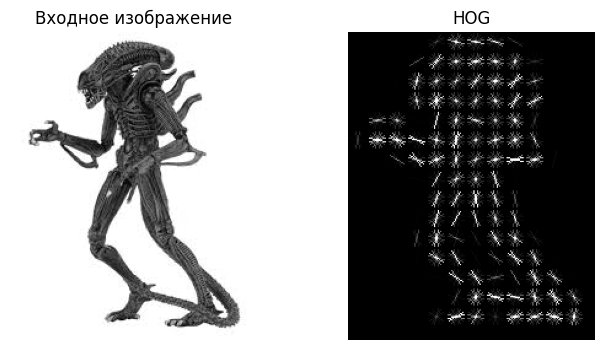

In [29]:
def imgHog(image):
    if len(image.shape) > 2:
        # Преобразовать цветное изображение в оттенки серого, если оно не таковы
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    fd, hog_image = hog(
        image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(4, 4),
        block_norm='L2',
        visualize=True,
    )
    return fd, hog_image


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fd, hog_image = hog(
    gray,
    orientations=8,
    pixels_per_cell=(16,16),
    cells_per_block=(4,4),
    visualize =True,
)

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(gray, cmap =plt.cm.gray)
ax1.set_title('Входное изображение')

hog_image_rescaled = exposure.rescale_intensity(hog_image,in_range=(0,20))

ax2.axis('off')
ax2.imshow(hog_image_rescaled,cmap=plt.cm.gray)
ax2.set_title('HOG')
plt.show()

In [30]:
images1 = list()
images2 = list()

for file in files_alien:
    img = cv2.imread(f'{input_path_alien}/{file}')
    if img is None:
        print(f"Error reading image: {input_path_alien}/{file}")
    else:
        images1.append(img)

for file in files_predator:
    img = cv2.imread(f'{input_path_predator}/{file}')
    if img is None:
        print(f"Error reading image: {input_path_predator}/{file}")
    else:
        images2.append(img)

images = images1 + images2

hog_images = []
hog_features = []
for image in images:
    if image is not None:  # Add a check for valid image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (300, 150), interpolation=cv2.INTER_AREA)
        fd, hog_image = imgHog(resized)
        hog_images.append(hog_image)
        hog_features.append(fd)
    else:
        print("Invalid image encountered in the loop.")

labels1 = [1 for i in range(len(images1))]
labels2 = [0 for i in range(len(images2))]
hog_features = np.array(hog_features)
labels = np.array(labels1 + labels2).reshape(len(images1) + len(images2), 1)
data_frame = np.hstack((hog_features, labels))
np.random.shuffle(data_frame)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels.flatten(), test_size=0.2, random_state=42)

# Обучение модели SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = svm_model.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nResults for SVM:")
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Разделение данных на обучающий и тестовый наборы для KNN
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(hog_features, labels.flatten(), test_size=0.2, random_state=42)

# Обучение модели KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_knn, y_train_knn)

# Прогнозирование на тестовом наборе для KNN
y_pred_knn = knn_model.predict(X_test_knn)

# Оценка производительности модели KNN
accuracy_knn = accuracy_score(y_test_knn, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test_knn, y_pred_knn)
class_report_knn = classification_report(y_test_knn, y_pred_knn)

print("\nResults for KNN:")
print(f"Accuracy: {accuracy_knn}")
print("Confusion Matrix:")
print(conf_matrix_knn)
print("Classification Report:")
print(class_report_knn)

# Точность (Accuracy): 69.4%

# Это процент правильных классификаций по всем изображениям в тестовом наборе. Значение 69.4% означает,
#  что модель довольно хорошо справляется с классификацией, но есть возможность улучшения.
# Матрица ошибок (Confusion Matrix):

# True Positive (TP): 41 изображение правильно классифицировано как класс 1 (хищники).
# True Negative (TN): 43 изображения правильно классифицировано как класс 0 (пришельцы).
# False Positive (FP): 14 изображений неверно классифицированы как класс 1.
# False Negative (FN): 23 изображения неверно классифицированы как класс 0.
# Отчет о классификации (Classification Report):

# Precision: Доля правильно предсказанных объектов внутри каждого класса.
# Recall: Доля объектов данного класса, которые модель правильно классифицировала.
# F1-score: Сбалансированная мера точности и полноты.

# Выводы:

# Модель показывает хорошие результаты для классификации пришельцев (класс 0) с высоким recall (0.75), 
# что означает, что модель хорошо обнаруживает пришельцев, но точность (0.65) немного ниже.
# Для классификации хищников (класс 1) recall и precision тоже хороши, но немного ниже, чем для класса 0.
# В целом, модель показывает неплохие результаты, но существует пространство для улучшения, возможно, 
# путем настройки параметров модели, увеличения объема данных или использования более сложных методов машинного обучения.


Results for SVM:
Accuracy: 0.6942148760330579

Confusion Matrix:
[[43 14]
 [23 41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70        57
           1       0.75      0.64      0.69        64

    accuracy                           0.69       121
   macro avg       0.70      0.70      0.69       121
weighted avg       0.70      0.69      0.69       121


Results for KNN:
Accuracy: 0.5454545454545454
Confusion Matrix:
[[55  2]
 [53 11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.96      0.67        57
           1       0.85      0.17      0.29        64

    accuracy                           0.55       121
   macro avg       0.68      0.57      0.48       121
weighted avg       0.69      0.55      0.47       121



In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Разделение данных на обучающий и тестовый наборы для Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(hog_features, labels.flatten(), test_size=0.2, random_state=42)

# Обучение модели Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Прогнозирование на тестовом наборе для Logistic Regression
y_pred_lr = lr_model.predict(X_test_lr)

# Оценка производительности модели Logistic Regression
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test_lr, y_pred_lr)
class_report_lr = classification_report(y_test_lr, y_pred_lr)

print("\nResults for Logistic Regression:")
print(f"Accuracy: {accuracy_lr}")
print("Confusion Matrix:")
print(conf_matrix_lr)
print("Classification Report:")
print(class_report_lr)


Results for Logistic Regression:
Accuracy: 0.7107438016528925
Confusion Matrix:
[[44 13]
 [22 42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        57
           1       0.76      0.66      0.71        64

    accuracy                           0.71       121
   macro avg       0.72      0.71      0.71       121
weighted avg       0.72      0.71      0.71       121



In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Разделение данных на обучающий и тестовый наборы для RandomForestClassifier
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(hog_features, labels.flatten(), test_size=0.2, random_state=42)

# Обучение модели RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_rf, y_train_rf)

# Прогнозирование на тестовом наборе для RandomForestClassifier
y_pred_rf = rf_model.predict(X_test_rf)

# Оценка производительности модели RandomForestClassifier
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
class_report_rf = classification_report(y_test_rf, y_pred_rf)

print("Results for RandomForestClassifier:")
print(f"Accuracy: {accuracy_rf}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print("Classification Report:")
print(class_report_rf)


Results for RandomForestClassifier:
Accuracy: 0.7603305785123967
Confusion Matrix:
[[46 11]
 [18 46]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        57
           1       0.81      0.72      0.76        64

    accuracy                           0.76       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.77      0.76      0.76       121

